# NLP sentiment analisis

## Imports

In [1]:
import pickle as pickle
import pandas as pd
import numpy as np

#keras to prepare data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#laeyers
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, Dropout
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization

#models
from keras.models import Sequential, Model

#train test split
from sklearn.model_selection import train_test_split

#for custom metric function
import tensorflow as tf
import keras.backend as K

#metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc

#optimizers
from keras.optimizers import Adam

#model vizualization
from keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


## Users functions

In [2]:
# AUC for a binary classifier
# from stackoverflow
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N

# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Loading data

In [3]:
raw_data = pd.read_csv('../data/class_data_001.csv', header = None)
raw_data.columns = ['label', 'text']
texts = raw_data.text.tolist()
labels = raw_data.label.values

## Preparing data

### Tokenization

In [4]:
#First of all we need to tokenize text. i'am using keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print( 'Found {} unique tokens.'.format( len(word_index)) )

Found 3552 unique tokens.


In [5]:
#lets compute max sequence lenth. We have to know it because it is the size of input vector.
#All text with lenth less then maximum should be padded to this size.
MAX_SEQUENCE_LENGTH = max(map(len, sequences))

In [6]:
#lets add 0 at the begining of sequenses (perform padding).
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

categorical_labels = to_categorical(np.asarray(labels))
print( 'Shape of data tensor: {}'.format(data.shape) )
print( 'Shape of label tensor: {}'.format(labels.shape) )

Shape of data tensor: (918, 210)
Shape of label tensor: (918,)


In [7]:
data[0,:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

There is pretrained word vectors called glove. It was mentioned in classes.

https://nlp.stanford.edu/projects/glove/

So i downloaded 6B tokens collection. It trained on wikipedia dump and gigaword 5 collection. It is provied as archive with text files. The text file structure is:

1st_token 1st_float_vector_element 2nd_float_vector_element ... last_float_vector_element \n

2nd_token 1st_float_vector_element 2nd_float_vector_element ... last_float_vector_element \n

etc

Lets do some preparations.

In [8]:
embeddings_index = {}
f = open('../data/glove.6B.50d.txt')
for line in f:
    values = line.split()
    #As i mention above 1st element is the token. We keep token in string word
    word = values[0]
    #The other elements is the elements of real value vector. We keep it as np.array.
    coefs = np.asarray(values[1:], dtype='float32')
    #Collecting dict. The keys of this dict is tokens and values is real vector elemnts.
    embeddings_index[word] = coefs
f.close()

print( 'Found {} word vectors.'.format(len(embeddings_index)) )

Found 400000 word vectors.


Lets check how many tokens from our collection does not appear in the pretrained Glove vectors.

In [9]:
glove_words = embeddings_index.keys()
ebsent_words = []
for word in word_index.keys():
    if not( word in glove_words ):
        ebsent_words.append(word)
        
print( 'There is no pretrained vectors for {} words.'.format(len(ebsent_words)) )

There is no pretrained vectors for 731 words.


Ok let see what kind of words are missing in the glove collection. This will help to understand is it because of lack tokens in glove collection or it is because of something else. 

In [10]:
ebsent_words[:20]

['goodfood',
 'flipdish',
 'agrariya',
 'purewine',
 'cropx',
 'scicrop',
 'gitgel',
 'cooked4u',
 'naio',
 'ecorobotix',
 'upgrain',
 'omicsis',
 'glasshous',
 'upcycled',
 'kitchfix',
 'urbanfarmers',
 'khepri',
 'microrganic',
 'zappfresh',
 'grocerkey']

Looks like few words was tokenized wrong. For example words with 's. "'s" is the particular token in glove collection and words with "'s" should be tokenized as two separate toekns. But most of words wich cant be found in glove collection is proper noun. So i think at this point this collection is enough.

### Creating embedding layer

In [11]:
#We used glove collection with 50 dimentional vectors. 
#But we could use 100 or 300 or any other number  presented in glove collection (50d in file name).
EMBEDDING_DIM = 50

In [12]:
def creat_emb(random_init = False):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            # probably we could random initialize them
            # to do this use random_init = True
        elif random_init:
            embedding_matrix[i] = np.random.rand(50)
    return embedding_matrix

In [13]:
emb = creat_emb()

In [14]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[emb],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Spliting data to validation and training.

For neuralnetwork training usualy use validation set instead crossvalidation. Lets separate data to train and validation set.

In [44]:
#because of unbalanced data i should use stratifyed spilt
train_index, validation_index = train_test_split(range(data.shape[0]), test_size = 0.3, stratify = labels)

x_train = data[train_index]
y_train = labels[train_index]
y_train_categorical = categorical_labels[train_index]

x_val = data[validation_index]
y_val = labels[validation_index]
y_val_categorical = categorical_labels[validation_index]

## Models

### Simple CNN

In [89]:
simple_cnn = Sequential([
    embedding_layer,
    SpatialDropout1D(0.2),
    Dropout(0.25),
    Conv1D(64, 5, padding='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [108]:
%%time
simple_cnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[auc, 'acc'])

CPU times: user 23.2 s, sys: 368 ms, total: 23.5 s
Wall time: 24.6 s


In [166]:
#plot_model(simple_cnn)

In [109]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 28s - loss: 0.6034 - auc: nan - acc: 0.6745 - val_loss: 0.4825 - val_auc: 0.9281 - val_acc: 0.7174
Epoch 2/2
642/642 [==============================] - 1s - loss: 0.4846 - auc: nan - acc: 0.7352 - val_loss: 0.3687 - val_auc: 0.9703 - val_acc: 0.7464

In [110]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 1s - loss: 0.3777 - auc: nan - acc: 0.7788 - val_loss: 0.2923 - val_auc: 0.9756 - val_acc: 0.8949
Epoch 2/2
642/642 [==============================] - 1s - loss: 0.3418 - auc: nan - acc: 0.8255 - val_loss: 0.2595 - val_auc: 0.9708 - val_acc: 0.9312

In [111]:
simple_cnn.save_weights('../data/simple_cnn.hdf5')

In [112]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 1s - loss: 0.3105 - auc: nan - acc: 0.8411 - val_loss: 0.2491 - val_auc: 0.9702 - val_acc: 0.9239
Epoch 2/2
642/642 [==============================] - 1s - loss: 0.2993 - auc: 0.9329 - acc: 0.8707 - val_loss: 0.2375 - val_auc: 0.9751 - val_acc: 0.9312

Simplest what can i do when NN stop learning is set learning rate lower and continue trying.

In [113]:
%%time
#default lr for Adam is 0.001 lets set it to 1e-4
simple_cnn.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-4), metrics=[auc, 'acc'])

CPU times: user 22.1 s, sys: 217 ms, total: 22.3 s
Wall time: 22.5 s


In [117]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=128)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 1s - loss: 0.2761 - auc: nan - acc: 0.8754 - val_loss: 0.2275 - val_auc: 0.9731 - val_acc: 0.9203
Epoch 2/2
642/642 [==============================] - 1s - loss: 0.2641 - auc: 0.9438 - acc: 0.8925 - val_loss: 0.2273 - val_auc: 0.9732 - val_acc: 0.9203

Does not help.

In [119]:
simple_cnn.load_weights('../data/simple_cnn.hdf5')
simple_cnn_pred = simple_cnn.predict(x_val)

Now it is time to try randomly initialization for missing words.

In [132]:
emb_rand = creat_emb(random_init = True)
embedding_layer_rand = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[emb_rand],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [140]:
simple_cnn = Sequential([
    embedding_layer_rand,
    SpatialDropout1D(0.2),
    Dropout(0.25),
    Conv1D(64, 5, padding='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [141]:
%%time
simple_cnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[auc, 'acc'])

CPU times: user 21.2 s, sys: 280 ms, total: 21.5 s
Wall time: 22 s


In [142]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 20s - loss: 0.5781 - auc: 0.6823 - acc: 0.6589 - val_loss: 0.4428 - val_auc: 0.9653 - val_acc: 0.7174

In [143]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 1s - loss: 0.3462 - auc: nan - acc: 0.7975 - val_loss: 0.3114 - val_auc: 0.9674 - val_acc: 0.9130

In [144]:
simple_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 1s - loss: 0.2932 - auc: 0.9403 - acc: 0.8583 - val_loss: 0.2491 - val_auc: 0.9714 - val_acc: 0.8877

Looks like random init for missing wards leads to increasing learning epochs. So there is reason to keep all missed vectors in one point because almost all this words means the same - company name or something similar.

## Simple CNN with categorical labels.

In some example peaple use categoracal labels with softmax activations in final layer.

In [151]:
simple_cnn = Sequential([
    embedding_layer,
    SpatialDropout1D(0.2),
    Dropout(0.25),
    Conv1D(64, 5, padding='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(2, activation='softmax')])

In [152]:
%%time
simple_cnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=[auc, 'acc'])

CPU times: user 21.6 s, sys: 325 ms, total: 21.9 s
Wall time: 22.9 s


In [153]:
simple_cnn.fit(x_train, y_train_categorical, validation_data=(x_val, y_val_categorical),
          epochs=4, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/4
642/642 [==============================] - 21s - loss: 0.5543 - auc: 0.7984 - acc: 0.7212 - val_loss: 0.4105 - val_auc: 0.9103 - val_acc: 0.7572

In [154]:
%%time
simple_cnn.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-4), metrics=[auc, 'acc'])

CPU times: user 25.1 s, sys: 359 ms, total: 25.4 s
Wall time: 26.1 s


In [155]:
simple_cnn.fit(x_train, y_train_categorical, validation_data=(x_val, y_val_categorical),
          epochs=4, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/4
642/642 [==============================] - 21s - loss: 0.2449 - auc: 0.9645 - acc: 0.8879 - val_loss: 0.2164 - val_auc: 0.9771 - val_acc: 0.9275

In [157]:
simple_cnn_cat_pred = simple_cnn.predict(x_val)

Observing result of metrics evaluation i can conclude that accuracy is a valid metric in this case. And there is no need to use badly optimized auc metric.

## Multi-size CNN

Same architecture idia as googlenet. Outputs from convolutional filters with different kernel size concatenates into a single volume.

In [169]:
graph_in = Input ((len(word_index) + 1, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Concatenate(axis=-1)(convs)  
graph = Model(graph_in, out) 

In [170]:
multy_cnn = Sequential ([
    embedding_layer,
    SpatialDropout1D(0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.7),
    Dense (1, activation='sigmoid')
    ])

In [177]:
%%time
multy_cnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['acc'])

CPU times: user 61.7 ms, sys: 2.05 ms, total: 63.8 ms
Wall time: 62.9 ms


In [179]:
multy_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=2, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/2
642/642 [==============================] - 13s - loss: 0.5300 - acc: 0.7103 - val_loss: 0.3454 - val_acc: 0.7572
Epoch 2/2
642/642 [==============================] - 1s - loss: 0.32

Results is better!!!

In [180]:
multy_cnn.save_weights('../data/multy_cnn.hdf5')

In [182]:
multy_cnn.load_weights('../data/multy_cnn.hdf5')

In [183]:
multy_cnn.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-4), metrics=['acc'])

In [184]:
multy_cnn.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=4, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/4
642/642 [==============================] - 11s - loss: 0.2590 - acc: 0.8754 - val_loss: 0.2313 - val_acc: 0.9239
Epoch 2/4
642/642 [==============================] - 1s - loss: 0.263

In [185]:
multy_cnn.load_weights('../data/multy_cnn.hdf5')

In [186]:
multy_cnn_preds = multy_cnn.predict(x_val)

## Wide & Deep model

Hope i understand it correctly because i did not read the paper. So i just put output of CNN and input sequence (210 int vector) into final dense layer.

In [246]:
graph_in = Input ((len(word_index) + 1, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Concatenate(axis=-1)(convs)  
graph = Model(graph_in, out) 

In [247]:
inp = Input (shape = (MAX_SEQUENCE_LENGTH,))
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = graph(x)
x = Dropout (0.5)(x)
x = Dense (100, activation="relu")(x)
x = Dropout (0.7)(x)
x = Concatenate(axis = -1)([inp, x])
out = Dense (1, activation='sigmoid')(x)
wide_deep = Model(inp, out)


In [248]:
wide_deep.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['acc'])

In [249]:
wide_deep.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/10
642/642 [==============================] - 12s - loss: 6.2036 - acc: 0.6028 - val_loss: 6.2509 - val_acc: 0.6051
Epoch 2/10
642/642 [==============================] - 1s - loss: 5.

It is does not learn. I think it is because the input is not normalized. And gradients is blowingup. I will try to add BatchNorm layer.

In [254]:
inp = Input (shape = (MAX_SEQUENCE_LENGTH,))
y = BatchNormalization()(inp)
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = graph(x)
x = Dropout (0.5)(x)
x = Dense (100, activation="relu")(x)
x = Concatenate(axis = -1)([y, x])
x = Dropout (0.7)(x)
out = Dense (1, activation='sigmoid')(x)
wide_deep = Model(inp, out)

In [255]:
wide_deep.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['acc'])

In [256]:
wide_deep.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/10
642/642 [==============================] - 12s - loss: 0.4359 - acc: 0.7944 - val_loss: 0.5063 - val_acc: 0.8007
Epoch 2/10
642/642 [==============================] - 2s - loss: 0.

In [258]:
wide_deep.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=1, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/1
642/642 [==============================] - 1s - loss: 0.0856 - acc: 0.9642 - val_loss: 0.2548 - val_acc: 0.9203


In [259]:
wide_deep.save_weights('../data/wide_deep.hdf5')

Still not so good as  Multi-size CNN, but it looks more stable (less overfitted).

In [260]:
wide_deep_preds = wide_deep.predict(x_val)

## Some conclusions

In [271]:
def get_score_to_plot(preds):
    fpr, tpr, _ = roc_curve(y_val, preds)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

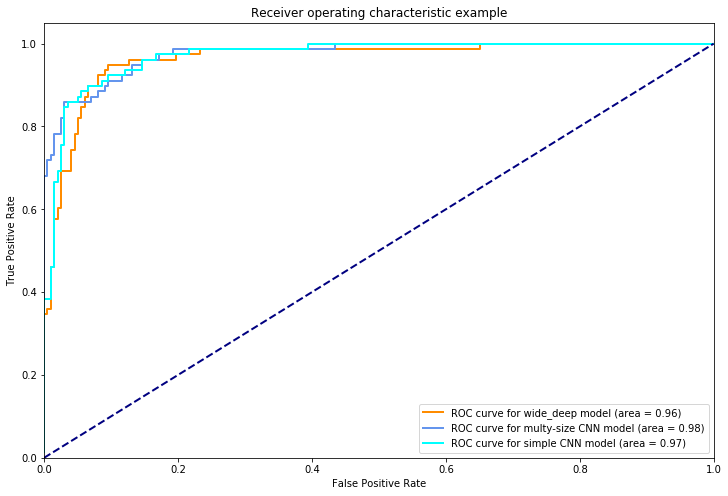

In [279]:
plt.figure(figsize=(12,8))
lw = 2
fpr, tpr, roc_auc = get_score_to_plot(wide_deep_preds)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve for wide_deep model (area = %0.2f)' % roc_auc)

fpr, tpr, roc_auc = get_score_to_plot(multy_cnn_preds)
plt.plot(fpr, tpr, color='cornflowerblue',
         lw=lw, label='ROC curve for multy-size CNN model (area = %0.2f)' % roc_auc)

fpr, tpr, roc_auc = get_score_to_plot(simple_cnn_pred)
plt.plot(fpr, tpr, color='aqua',
         lw=lw, label='ROC curve for simple CNN model (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [61]:
inp = Input (shape = (MAX_SEQUENCE_LENGTH,))
y = BatchNormalization()(inp)
x = embedding_layer(inp)
conv_in = SpatialDropout1D(0.2)(x)

convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding='same', activation="relu")(conv_in)
    x = MaxPooling1D()(x) 
    #x = Flatten()(x) 
    convs.append(x)
sec_conv = Concatenate(axis=-1)(convs)
#x = Conv1D(128, 3, padding='same', activation="relu")(x)
#sec_conv = Flatten()(x)

convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding='same', activation="relu")(sec_conv)
    #x = MaxPooling1D()(x) 
    #x = Flatten()(x) 
    convs.append(x)
x = Concatenate(axis=-1)(convs)
#x = Conv1D(128, 3, padding='same', activation="relu")(x)
x = Flatten()(x)

#x = graph(x)
x = Dropout (0.5)(x)
x = Dense (100, activation="relu")(x)
#x = Dropout (0.7)(x)
x = Concatenate(axis = -1)([y, x])
#x = Dropout (0.4)(x)
out = Dense (1, activation='sigmoid')(x)
wide_deep = Model(inp, out)

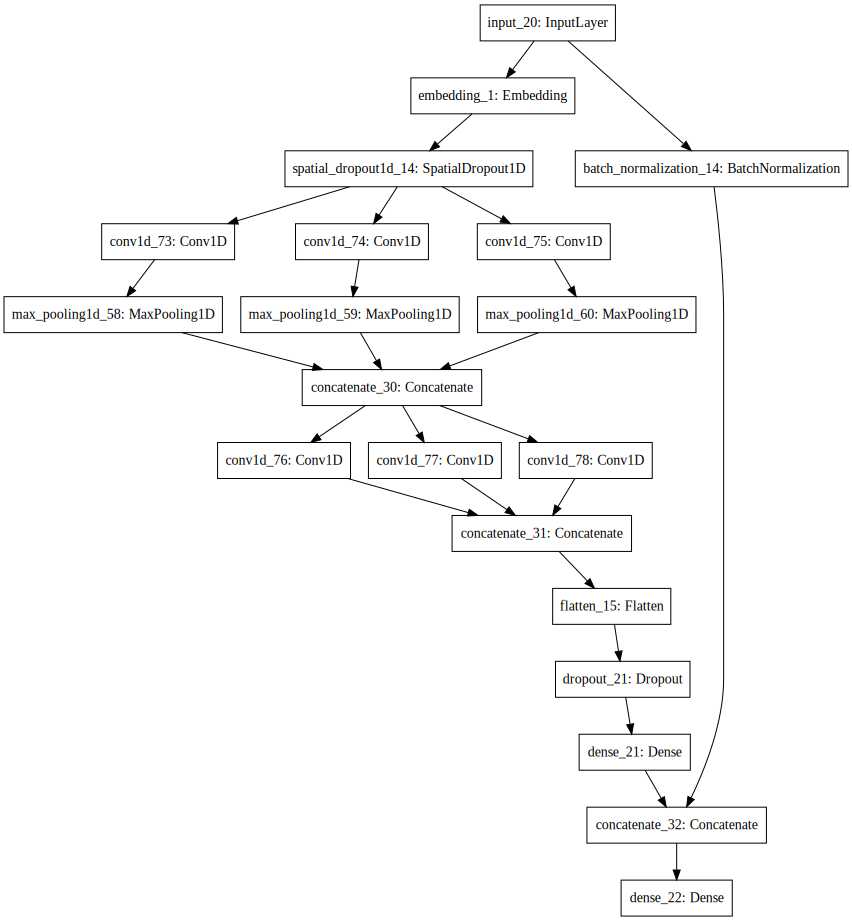

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

visualize_model(wide_deep)

In [65]:
wide_deep.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=64)

Train on 642 samples, validate on 276 samples
Epoch 1/10
642/642 [==============================] - 6s - loss: 0.2122 - acc: 0.9143 - val_loss: 0.3125 - val_acc: 0.8732
Epoch 2/10
642/642 [==============================] - 6s - loss: 0.2179 - acc: 0.9034 - val_loss: 0.3086 - val_acc: 0.8732
Epoch 3/10
642/642 [==============================] - 7s - loss: 0.2032 - acc: 0.9206 - val_loss: 0.2993 - val_acc: 0.8732
Epoch 4/10
642/642 [==============================] - 7s - loss: 0.1678 - acc: 0.9252 - val_loss: 0.2902 - val_acc: 0.8877
Epoch 5/10
642/642 [==============================] - 6s - loss: 0.1599 - acc: 0.9377 - val_loss: 0.3048 - val_acc: 0.8768
Epoch 6/10
642/642 [==============================] - 6s - loss: 0.1718 - acc: 0.9283 - val_loss: 0.3095 - val_acc: 0.8768
Epoch 7/10
642/642 [==============================] - 6s - loss: 0.1526 - acc: 0.9393 - val_loss: 0.3010 - val_acc: 0.9058
Epoch 8/10
642/642 [==============================] - 6s - loss: 0.1315 - acc: 0.9470 - val_l

In [67]:
import NLTK

ImportError: No module named NLTK

In [68]:
import tensorflow as tf

In [77]:
#abstracting our layers and weight creation

def embadding_weights(embedding_array):
    return tf.Variable(embedding_array)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def embedding(x, W):
    return tf.nn.embedding_lookup(W, x)

def conv1d(x, W):
  return tf.nn.conv1d(x, W, strides=[1, 1, 1], padding='SAME')

def max_pool(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 1],
                        strides=[1, 2, 1], padding='SAME')

def simpleCNN(x):
    """Our input is int vector wich represent text sequence.
    Embedding layer is map int numbers to real vectors accordind embedding matrix"""
    
    W_emb = embedding_weights(emb)
    real_vecs = embedding(x, W_emb)
    
    #1st conv layer
    W_conv1 = weight_variable([5, 1, 32])
    

sess = tf.InteractiveSession()

#placeholder for input data
x = tf.placeholder(tf.int32, shape=[None, MAX_SEQUENCE_LENGTH])
#placeholder for labels
y = tf.placeholder(tf.int32, shape=[None,1])



In [73]:
a = tf.placeholder(tf.int32)
b = tf.placeholder(tf.float32)

real_vec = tf.nn.embedding_lookup(b, a)

print(sess.run(real_vec, {a: [3,4], b: emb}))

[[  6.18499994e-01   6.42539978e-01  -4.65519994e-01   3.75699997e-01
    7.48380005e-01   5.37389994e-01   2.22390005e-03  -6.05769992e-01
    2.64079988e-01   1.17030002e-01   4.37220007e-01   2.00920001e-01
   -5.78589998e-02  -3.45889986e-01   2.16639996e-01   5.85730016e-01
    5.39189994e-01   6.94899976e-01  -1.56179994e-01   5.58300018e-02
   -6.05149984e-01  -2.89970011e-01  -2.55939998e-02   5.55930018e-01
    2.53560007e-01  -1.96120000e+00  -5.13809979e-01   6.90959990e-01
    6.62460029e-02  -5.42239994e-02   3.78710008e+00  -7.74030030e-01
   -1.26890004e-01  -5.14649987e-01   6.67050034e-02  -3.29329997e-01
    1.34829998e-01   1.90490007e-01   1.38119996e-01  -2.15030000e-01
   -1.65730007e-02   3.12000006e-01  -3.31889987e-01  -2.60010008e-02
   -3.82030010e-01   1.94030002e-01  -1.24660000e-01  -2.75570005e-01
    3.08990002e-01   4.84970003e-01]
 [  2.17050001e-01   4.65149999e-01  -4.67570007e-01   1.00819997e-01
    1.01349998e+00   7.48449981e-01  -5.31040013e-01 

In [75]:
emb[3:5]

array([[  6.18499994e-01,   6.42539978e-01,  -4.65519994e-01,
          3.75699997e-01,   7.48380005e-01,   5.37389994e-01,
          2.22390005e-03,  -6.05769992e-01,   2.64079988e-01,
          1.17030002e-01,   4.37220007e-01,   2.00920001e-01,
         -5.78589998e-02,  -3.45889986e-01,   2.16639996e-01,
          5.85730016e-01,   5.39189994e-01,   6.94899976e-01,
         -1.56179994e-01,   5.58300018e-02,  -6.05149984e-01,
         -2.89970011e-01,  -2.55939998e-02,   5.55930018e-01,
          2.53560007e-01,  -1.96120000e+00,  -5.13809979e-01,
          6.90959990e-01,   6.62460029e-02,  -5.42239994e-02,
          3.78710008e+00,  -7.74030030e-01,  -1.26890004e-01,
         -5.14649987e-01,   6.67050034e-02,  -3.29329997e-01,
          1.34829998e-01,   1.90490007e-01,   1.38119996e-01,
         -2.15030000e-01,  -1.65730007e-02,   3.12000006e-01,
         -3.31889987e-01,  -2.60010008e-02,  -3.82030010e-01,
          1.94030002e-01,  -1.24660000e-01,  -2.75570005e-01,
        